In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))
    
def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 989
    display(IFrame(src, width, height))

# Lecture 19 – Bootstrap, Percentiles, and Confidence Intervals

## DSC 10, Summer 2022

### Announcements

- HW 5 is due **tomorrow at 11:59pm**.
- Lab 6 is due **Tuesday at 11:59pm**.

### Agenda

- Bootstrapping.
- Percentiles.
- Confidence intervals.

## Bootstrapping 🥾

### City of San Diego employee salary data

All City of San Diego employee salary data [is public](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2020&rpt=1). We are using the latest available data.

In [2]:
population = bpd.read_csv('data/2020_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2020,City,San Diego,Police,...,San Diego,NaN,False,NaN
1,2020,City,San Diego,Police,...,San Diego,NaN,False,NaN
2,2020,City,San Diego,Retirement,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12601,2020,City,San Diego,Engineering & Capital Projects,...,San Diego,NaN,False,NaN
12602,2020,City,San Diego,Planning,...,San Diego,NaN,False,NaN
12603,2020,City,San Diego,Transportation,...,San Diego,NaN,False,NaN


When you load in a dataset that has so many columns that you can't see them all, it's a good idea to look at the column names.

In [3]:
population.columns

Index(['Year', 'EmployerType', 'EmployerName', 'DepartmentOrSubdivision',
       'Position', 'ElectedOfficial', 'Judicial', 'OtherPositions',
       'MinPositionSalary', 'MaxPositionSalary', 'ReportedBaseWage',
       'RegularPay', 'OvertimePay', 'LumpSumPay', 'OtherPay', 'TotalWages',
       'DefinedBenefitPlanContribution', 'EmployeesRetirementCostCovered',
       'DeferredCompensationPlan', 'HealthDentalVision',
       'TotalRetirementAndHealthContribution', 'PensionFormula', 'EmployerURL',
       'EmployerPopulation', 'LastUpdatedDate', 'EmployerCounty',
       'SpecialDistrictActivities', 'IncludesUnfundedLiability',
       'SpecialDistrictType'],
      dtype='object')

### We only need the total wages...

In [4]:
population = population.get(['TotalWages'])
population

,TotalWages
0,320699
1,318312
2,317814
...,...
12601,1
12602,1
12603,1


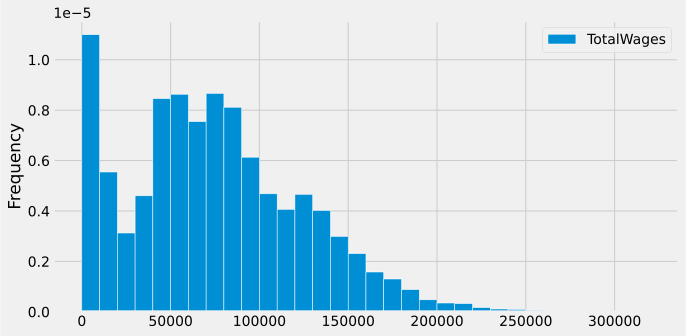

In [5]:
population.plot(kind='hist', bins=np.arange(0, 325000, 10000), density=True, ec='w', figsize=(10, 5));

### The median salary

- We can use `.median()` to find the median salary of all city employees.
- This is **not** a random quantity.

In [6]:
population_median = population.get('TotalWages').median()
population_median

71354.5

### Let's be realistic...

- In practice, it is costly and time-consuming to survey **all** 12,000+ employees.
    - More generally, we can't expect to survey all members of the population we care about.
- Instead, we gather salaries for a random sample of, say, 500 people.
- Hopefully, the median of the sample is close to the median of the population.

### In the language of statistics

- The full DataFrame of salaries is the **population**.
- We observe a **sample** of 500 salaries from the population.
- We want to determine the **population median (a parameter)**, but we don't have the whole population, so instead we use the **sample median (a statistic) as an estimate**.
- Hopefully the sample median is close to the population median.

### The sample median

- Let's survey 500 employees at random.
- We can use `.sample()`:

In [7]:
np.random.seed(23) # Magic to ensure that we get the same results every time this code is run

# Take a sample of size 500
my_sample = population.sample(500)
my_sample

,TotalWages
9749,36727
10369,23584
8529,49460
...,...
3991,93828
8397,50704
5994,74289


We won't reassign `my_sample` at any point in this notebook, so it will always refer to this particular sample.

In [8]:
# Compute the sample median
sample_median = my_sample.get('TotalWages').median()
sample_median

69616.0

### How confident are we that this is a good estimate?

- `sample_median` is \\$69616. That's our best guess for the actual population median.
- But...our estimate depended on a random sample.
- If our sample was different, our estimate may have been different, too.
- **How different could our estimate have been?**
- Our confidence in the estimate depends on the answer to this question.

### The sample median is random

- The sample median is a random number.
- It comes from some distribution, which we don't know.
- How different could our estimate have been, if we drew a different sample?
    - "Narrow" distribution $\Rightarrow$ not too different.
    - "Wide" distribution $\Rightarrow$ quite different.
- **What is the distribution of the sample median?**

### What we've done before

- One idea: repeatedly collect random samples of 500 **from the population** and compute its median.
    - This is what we did in Lecture 14 to compute an empirical distribution of the sample mean of flight delays.
- We can plot the empirical distribution of the sample median with a histogram.
- This is an approximation of the true distribution of the sample median, using 1000 samples.

In [9]:
sample_medians = np.array([])
for i in np.arange(1_000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([72337.5, 72434. , 73883. , ..., 71348.5, 70084. , 72311.5])

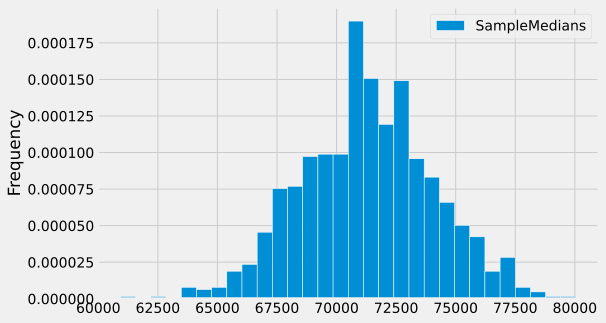

In [10]:
(bpd.DataFrame()
 .assign(SampleMedians=sample_medians)
 .plot(kind='hist', density=True,
       bins=30, ec='w', figsize=(8, 5))
);

### The problem

- Drawing new samples like this is impractical.
    - If we were able to do this, why not just collect more data in the first place?
- Often, we can't ask for new samples from the population.
- **Key insight:** our original sample, `my_sample`, looks a lot like the population.
    - Their distributions are similar.

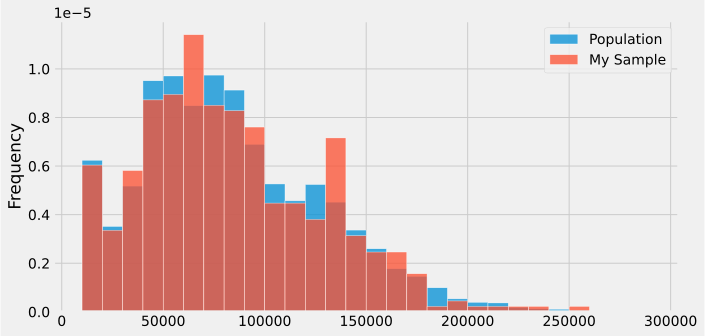

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
bins=np.arange(10_000, 300_000, 10_000)
population.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
my_sample.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
plt.legend(['Population', 'My Sample']);

Note that unlike the previous histogram we saw, this is depicting the distribution of the population and of one particular sample (`my_sample`), **not** the distribution of sample medians for 246 samples.

### The bootstrap

- **Big idea:** Use the sample to simulate more samples.
    - The sample itself looks like the population.
    - So, resampling from the sample is like sampling from the population.
    - The act of resampling from a sample is called **bootstrapping** or "**the bootstrap**" method.

- In our case specifically:
    - We have a sample of 500 salaries.
    - We want another sample of 500 salaries, but we can't draw from the population.
    - However, the original sample looks like the population.
    - So, let's just **resample from the sample!**

In [12]:
show_bootstrapping_slides()

### Resampling with replacement

When bootstrapping, we resample **with** replacement. Why? 🤔

### Resampling with replacement

- Our goal when bootstrapping is to create a sample of the same size as our original sample.
- If we were to resample without replacement $n$ times from an original sample of size $n$, our resample would look exactly the same as the original sample.
    - For instance, if we sample 5 elements without replacement from `['A', 'B', 'C', 'D', 'E']`, our sample will contain the same 5 characters, just in a different order.
- So, we need to sample **with replacement** to ensure that our resamples can be different from the original sample.
- Why does this work? If we assume population is large, sampling with replacement is approx the same as sampling without replacement.

### Running the bootstrap

- We can simulate the act of collecting new samples by **sampling with replacement from our original sample, `my_sample`**.

In [13]:
# Note that the population DataFrame doesn't appear anywhere here!

n_resamples = 5000
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample WITH REPLACEMENT
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians
    boot_medians = np.append(boot_medians, median)

In [14]:
boot_medians

array([72700., 69640., 68606., ..., 69198., 69989., 72850.])

### Bootstrap distribution of the sample median

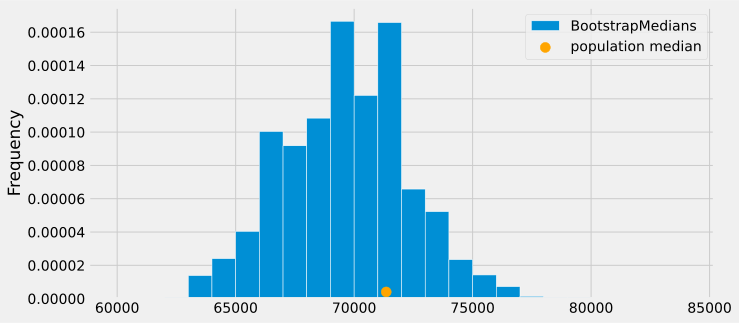

In [15]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- The population median (orange dot) is near the middle.
    - **In reality, we'd never get to see this!**

## What's the bootstrap useful for?

- We have a sample median wage:

In [16]:
my_sample.get('TotalWages').median()

69616.0

- And now we can say: the population median wage is approx \\$69616.
    - But how approximate?

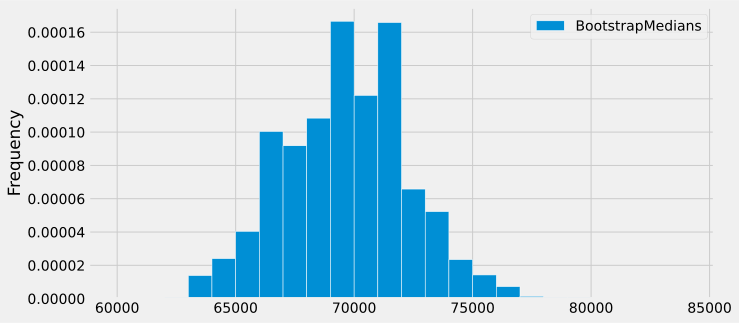

In [17]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
)
# plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- So now we can say: my guess for the population median wage is that it's between \\$65,000 and \\$75,000.

### You Try: Bootstrap the sample median

1. Simulate another sample by resampling 500 items from `my_sample` with replacement. Then, find the median of each bootstrap sample.
1. Repeat step 1 5,000 times. Store results in an array called `boot_medians`.
1. Plot a histogram of the bootstrap medians.
1. Say what your best guess for the population median is.

Yes, I know that we just wrote the code for this. Try to write it again without looking at the answer!

In [18]:
# Note that the population DataFrame doesn't appear anywhere here!
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    
    # Resample from my_sample
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians
    boot_medians = np.append(boot_medians, median)

boot_medians

array([71137. , 70565.5, 75368. , ..., 69616. , 71426.5, 69267. ])

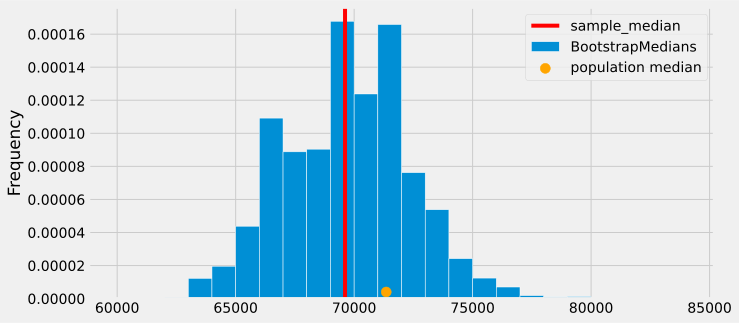

In [19]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- We can only plot the orange dot because we happen to know the population parameter in this case (for teaching purposes).
    - In reality, you will not know the population parameter!
- If we just look at the bootstrap distribution, what's our best guess for the population median?
    - \\$65,000 to \\$75,000?
    - \\$68,000 to \\$72,000?
    - Something else?
- **Idea:** Find the range that captures the middle 95% of the values.

## Percentiles

### Mathematical definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is **always an element of the collection.** 

### How to calculate percentiles using mathematical definition

Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.
2. Define $h$ to be $p\%$ of $n$: 

$$h = \frac p{100} \cdot n$$

3. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.

4. Take the $k$th element of the sorted collection (start counting from 1, not 0).

### Example

Let's say we have an array: `np.array([4, 10, 15, 21, 100, 120])`. Here's what our percentile formula does:

| data       | 4       | 10       | 15       | 21       | 100       | 120 |
|------------|---------|----------|----------|----------|-----------|-----|
| percentile | [0, 20) | [20, 40) | [40, 60) | [60, 80) | [80, 100) | 100 |

So, the 8th percentile is `4`. The 60th percentile is `21`. Etc.

- The median is the 50th percentile: `15`.
- Easiest way to remember:
    - First item in array is the 0th percentile.
    - Last item in array is the 100th percentile.
    - Split up the rest of the range evenly.
    - When you're in between two percentiles, choose the lower array item.

### You Try:

What is the 50th percentile (the median) of this array?

What about the 70th percentile?

`np.array([70, 18, 56, 89, 55, 35, 10, 45])`

### Calculating the percentile using our mathematical definition

In [20]:
def percentile(data, p):
    data = sorted(data)
    n = len(data)
    h = (p / 100) * n
    k = int(np.ceil(h)) # If h is an integer, this is h. Otherwise, rounds up.
    return data[k - 1] # -1 because Python is 0-indexed, but regular math is 1-indexed.

In [21]:
example = np.array([70, 18, 56, 89, 55, 35, 10, 45])
percentile(example, 50)

45

### Another definition of percentile

- The `numpy` package provides a function to calculate percentiles, `np.percentile(array, p)`, which returns the `p`th percentile of `array`.
- To do our definition of percentile, use `interpolation='lower'`.

In [22]:
np.percentile(example, 50, interpolation='lower')

45

## Confidence intervals

### Using the bootstrap distribution

- Now, let's return to our original question:
    - We have a sample median (around \\$69k).
    - This means that we think that the population median is close to \\$69k.
    - How do we capture our uncertainty about this guess?
- Idea: Find a range that captures most of the bootstrap distribution.

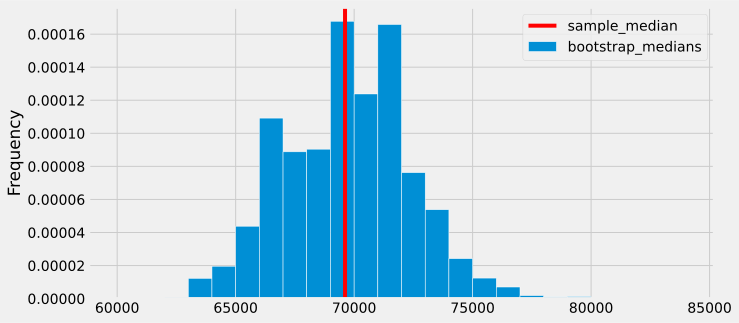

In [23]:
bpd.DataFrame().assign(bootstrap_medians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.legend();

### Confidence intervals

Let's state it using statistical lingo:

- Goal: estimate an unknown population parameter.
- We have been saying 
>"My guess for the population parameter is my sample statistic, $x$."
- We want to say 
>"My guess is that the population parameter is between $a$ and $b$."
- Let's use the bootstrapped distribution of an estimate to compute an **interval** that contains "the bulk" of the estimates.

### Finding endpoints

- We want to find two points, $x$ and $y$, such that the area:
    - to the left of $x$ is about 2.5%.
    - to the right of $y$ is about 2.5%.
- The interval $[x,y]$ will contain about 95% of the total area, i.e. 95% of the total values.
- $x$ and $y$ are the **2.5th percentile** and **97.5th percentile**, respectively.

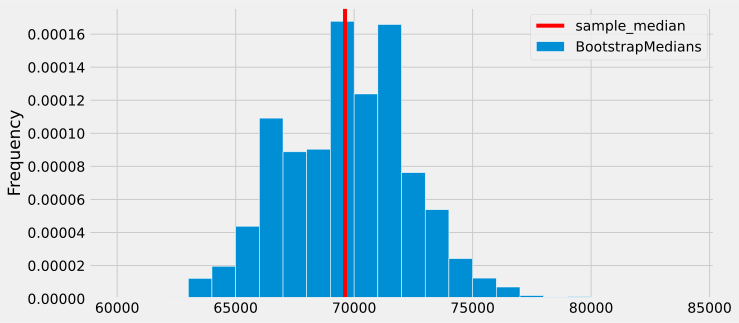

In [24]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.legend();

In [25]:
# Left endpoint
left = np.percentile(boot_medians, 2.5, interpolation='lower')
left

64832.5

In [26]:
# Right endpoint
right = np.percentile(boot_medians, 97.5, interpolation='lower')
right

74788.5

In [27]:
# Therefore, our interval is
[left, right]

[64832.5, 74788.5]

You will use the code above **very** frequently moving forward!

### Visualizing our 95% confidence interval

- Let's draw the interval we just computed on the histogram.
- 95% of the bootstrap medians fell into this interval.

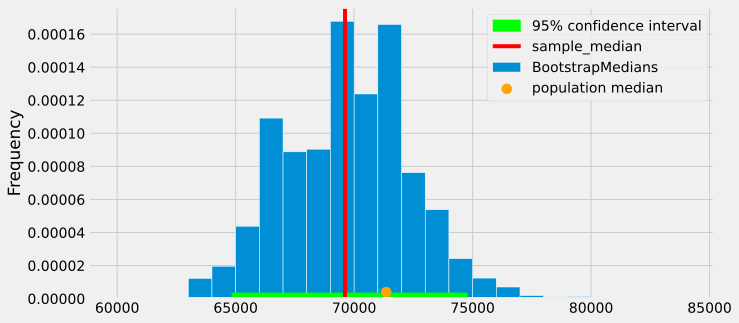

In [45]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=12, label='95% confidence interval');
plt.axvline(sample_median, c='r', label='sample_median');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(3)
plt.legend();

- In this case, our 95% confidence interval (lime green) contains the true population parameter (orange dot).
    - It won't always, because you might have a bad original sample!
    - In reality, you won't know where the population parameter is, and so you won't know if your confidence interval contains it.

### You Try: Confidence levels

The code above finds the 95% confidence interval. Will the 80% confidence interval be wider or narrower than the 95% interval? Take a guess, then write code to compute the 80% confidence interval.

Explain the pros and cons of using an 80% interval instead of a 95%.

  - We haven't covered how to do this exactly, but take your best guess.

In [29]:
left80 = np.percentile(boot_medians, 10, interpolation='lower')
right80 = np.percentile(boot_medians, 90, interpolation='lower')
[left80, right80]

[66213.0, 73041.0]

In [30]:
# 95% confidence
[left, right]

[64832.5, 74788.5]

## Interpreting confidence intervals

### Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval.
- We're pretty confident that the true median does, too.
- How confident should we be about this? **What does a 95% confidence interval mean?**

### Capturing the true value

- Consider the process of:
    - Collecting a **new original sample** from the population,
    - Bootstrap resampling from it many times, computing the statistic (e.g. median) in each resample, and
    - Constructing a new 95% confidence interval.
- What a 95% confidence level states is that **approximately 95% of the time, the intervals you create through this process will contain the true population parameter**.
- The confidence is in **the process** that generates the interval.

### Many confidence intervals

- We repeated the process outlined on the previous slide 200 times, to come up with 200 confidence intervals.
    - We did this in advance and saved the results to a file to save time.
- The resulting CIs are stored in the array `many_cis` below.

In [31]:
many_cis = np.load('data/many_cis.npy')
many_cis

array([[64954.12, 76985.06],
       [64961.  , 76063.  ],
       [64757.5 , 74301.96],
       ...,
       [64599.2 , 77106.36],
       [60956.57, 71571.11],
       [67632.39, 78566.41]])

In the visualization below,
- The orange line represents the population parameter. **This is not random.**
- Each green line represents a separate confidence interval, created using the specified process.
- Most of these confidence intervals contain the true parameter – but not all!

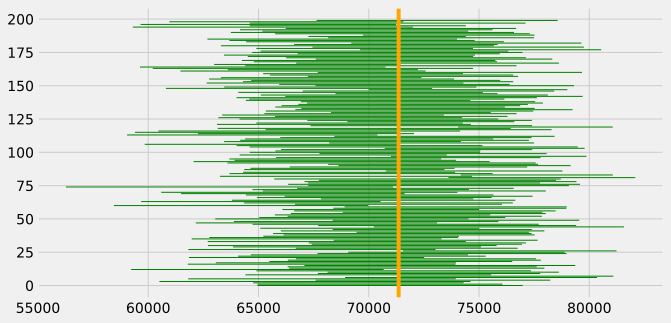

In [32]:
plt.figure(figsize=(10, 5))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
plt.axvline(x=population_median, color='orange');

### Which confidence intervals don't contain the true parameter?

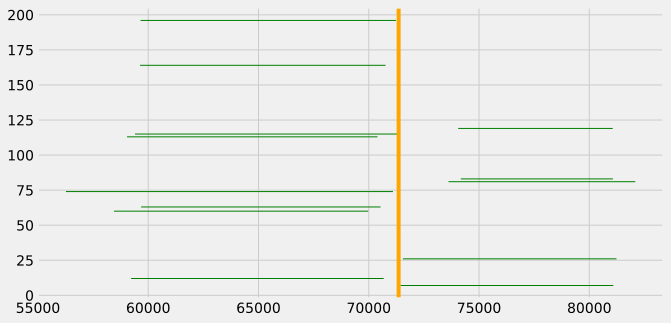

In [33]:
plt.figure(figsize=(10, 5))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='orange');

In [34]:
count_outside

13

- 13 of my 200 confidence intervals didn't contain the true parameter.
- That means 187/200, or 93.5% of them, did.
    - This is pretty close to 95%!
- In reality, you will have **no way of knowing if your confidence interval contains the true parameter**, since you have no way of knowing if your original sample is good.

### Confidence Tradeoffs

- If I choose 95% confidence, about 5% of my samples will be "unlucky".
    - When I use an unlucky sample to make my CI, the CI won't contain the population parameter.
- If I choose 80% confidence, about 20% of my samples will be unlucky.
    - But, my confidence interval will be narrower, which means I'm making a more precise estimation.
- How do I have high confidence and high precision?
    - Take a big sample!

### Misinterpreting confidence intervals

- Confidence intervals are confusing. Here are a few common misconceptions.

In [35]:
# Our interval
[left, right]

[64832.5, 74788.5]

- It is **not true** that this interval contains 95% of all salaries.
- Instead, it is true that this interval contains 95% of all bootstrapped **median** salaries.

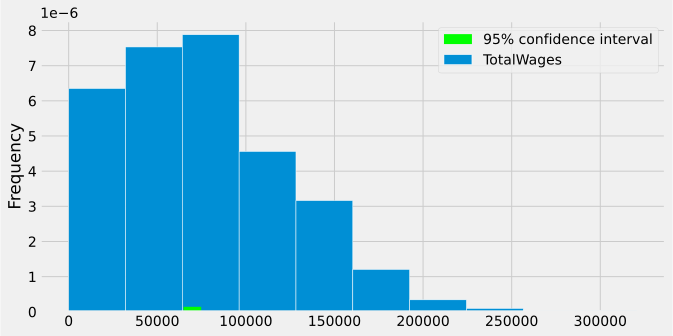

In [36]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=10, label='95% confidence interval');
plt.legend();

### Misinterpreting confidence intervals

In [37]:
# Our interval
[left, right]

[64832.5, 74788.5]

- It is **not true** that there is a 95% chance that the interval above contains the population parameter.
    - Once I have a sample, the interval is (essentially) fixed.
    - Either the population parameter is in the interval, or it is not. There is no randomness involved.
- Remember that the 95% confidence is in the process that created an interval.
    - This process (sampling, then bootstrapping, then creating an interval) has a roughly 95% chance of creating a good interval.
    - 95% confidence needs all three steps. Can't skip the first one!

In [38]:
show_confidence_interval_slides()

### Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We only had to collect a single sample from the population to get the (approximate) distribution of the sample median.
- But it has limitations:
    - It is not good for sensitive statistics, like the max or min.
    - It requires the sample to be a good approximation of population.
        - If our original sample was not representative of the population, the resulting bootstrapped samples will also not be representative of the population.

### Example: estimating the max of a population

Suppose we want to estimate the maximum salary of all San Diego city employees, given just a single sample `my_sample`.

In [39]:
# The true maximum salary in the population
population_max = population.get('TotalWages').max()
population_max

320699

### Running the bootstrap

- We want to estimate the maximum number in the population.
- Our estimate will be the max in the sample.
- We run the bootstrap:

In [40]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):

    resample = my_sample.sample(my_sample.shape[0], replace=True)
    
    boot_max = resample.get('TotalWages').max()
    
    boot_maxes = np.append(boot_maxes, boot_max)

In [41]:
boot_maxes

array([230087., 257062., 257062., ..., 257062., 257062., 257062.])

### Visualize

The bootstrap distribution doesn't capture the population maximum (orange dot) of 320699. Why not? 🤔

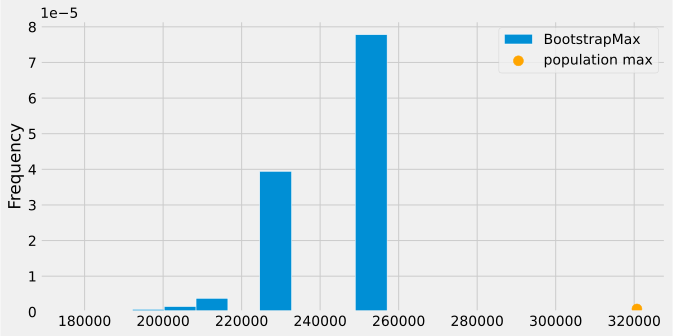

In [42]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='orange', s=100, label='population max')
plt.legend();

### Why did that happen?

In [43]:
my_sample.get('TotalWages').max()

257062

- The largest value in our original sample was 257062. 
- Therefore, the largest value in any bootstrapped sample is at most 257062.
- Generally, the bootstrap works better for measures of central tendency or variation (means, medians, variances) than it does for extremas (maxes and mins).

## Why does it matter?

- Now, we're learning estimation techniques that are more applicable to real life.
- Real life: no population, only a sample!
- Using the bootstrap lets us **quantify uncertainty**.
- "How long does it take to drive to the airport?"
    - "Around 25-35 minutes."
- In the past week, we're making this reasoning rigorous.
- Confidence intervals are used basically whenever we're uncertain about something.
    - In engineering: when will this part break?
    - In business: how much profit will we make next month? 
    - In economics: how will the inflation rate affect markets?
- Next time: we'll connect CIs with hypothesis testing.